In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84125825/84125825 [==============================] - 13s 0us/step


['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [3]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

Removing unnecessary folder

In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [13]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Lets see some examples

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

# Preprocessing

`tf.keras.layers.TextVectorization` performs:
- Standardization: sanitizing the text *(default: converts text to lowercase and strips punctuation)*
- Tokenization: splitting strings into tokens *(default: by whitespace)*
- Vectorization: converting tokens into numbers *(default: int)*

You can also use `text.BertTokenizer` with a `BERT` model to simplify the preprocessing.

In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [16]:
max_features = 10000 # vocabulary size
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize=custom_standardization, max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)

Fit (create the vocabulary) **only** over the Train data (using the test set would leak information)

In [17]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [20]:
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Vocabulary size: 10000


Transformation function

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [38]:
#testing
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
vectext = vectorize_text(first_review, first_label)
word1 = vectext[0].numpy()[0][0]
word2 = vectext[0].numpy()[0][1]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectext)

print(word1, " ---> ",vectorize_layer.get_vocabulary()[word1])
print(word2, " ---> ",vectorize_layer.get_vocabulary()[word2])

Review tf.Tensor(b"I went to see Fever Pitch with my Mom, and I can say that we both loved it. It wasn't the typical romantic comedy where someone is pining for the other, and blah blah blah... You weren't waiting for the climatic first kiss or for them to finally get together. It was more real, because you saw them through the relationship, rather than the whole movie be about them getting together. People could actually relate to the film, because it didn't seem like extraordinary circumstances, or impossible situations. It was really funny, and I think it was Jimmy Fallon's best performance. All in all... I would definitely recommend it!", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  426,    6,   67, 3775, 3322,   16,   54, 1611,    3,   10,
          68,  131,   12,   71,  192,  446,    9,    9,  269,    2,  769,
         736,  220,  114,  282,    7,    1,   15,    2,   78,    3, 2642,
        2642, 2642,   22, 

## Apply over the whole Dataset

In [39]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Cache

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Simple Model

The model:
- Embed a 10,000 word vocabulary into 16 dense dimensions representation, returns dimensions `(batch, sequence, embedding)`
- Global average over the `sequence` dimension, so the model handles reviews with any sequence size, returns `(batch, embedding)`
- Densely connects and output a *logit*

In [41]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim), # max_features = vocab size
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

## More models

You can also create a different models if using different texts preprocessings:
- If use a `output_mode='binary'` in `TextVectorization`, you can use a linear model
- If use a `output_mode='int'` in `TextVectorization`, you can use a convolutional model

In [ ]:
linear_model = tf.keras.Sequential([layers.Dense(1)])

conv_model = tf.keras.Sequential([
      layers.Embedding(max_features, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(1)
  ])

## Continuing...

In [42]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [43]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 9s 13ms/step - loss: 0.6656 - binary_accuracy: 0.6909 - val_loss: 0.6168 - val_binary_accuracy: 0.7730
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5497 - binary_accuracy: 0.8000 - val_loss: 0.4988 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4450 - binary_accuracy: 0.8442 - val_loss: 0.4202 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3785 - binary_accuracy: 0.8665 - val_loss: 0.3737 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3355 - binary_accuracy: 0.8781 - val_loss: 0.3451 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3056 - binary_accuracy: 0.8888 - val_loss: 0.3261 - val_binary_accuracy: 0.8730
Epoch 7/10
625/625 [==============================] - 3s 4ms/st

In [44]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.3105 - binary_accuracy: 0.8731
Loss:  0.3105087876319885
Accuracy:  0.8731200098991394


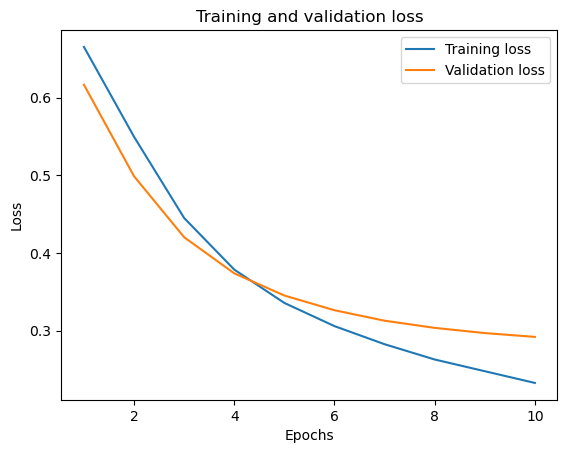

In [46]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

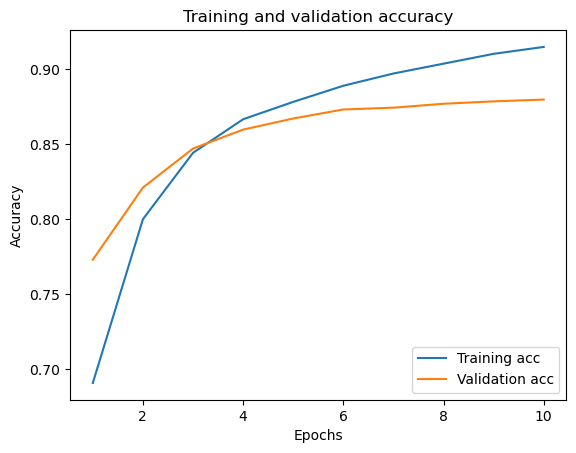

In [47]:
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Conslusion

Its possible to notice that the model performs way better on the training data than it does on data it has never seen before.

This model is **overfitted**, for this simpler case, a `EarlyStopping` callback should be enough to prevent the overfitting.

## Exportation

To ease the exportation and deployment of the model, and to avoid train/test skew on data, you might want to include the text preprocessing in the model

In [48]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy'])

In [49]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 146ms/step


array([[0.6170986 ],
       [0.4380344 ],
       [0.35528472]], dtype=float32)

`export_model` can be saved in just one model file

If necessary, you can also export a vocabulary from some *tokenizer* to another

In [ ]:
new_preprocess_layer = layers.TextVectorization(...)
new_preprocess_layer.set_vocabulary(vectorize_layer.get_vocabulary())